<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/cw_cl/Lesson1_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 1: Fitting Neural Network Models**

In this tutorial, we will learn how to use a neural network model to predict the energy of points on the Müller-Brown potential energy surface.

For the definition of Müller-Brown potential, see https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $



In [139]:
#@markdown [Task 1.1) Defining the Müller-Brown Potential Energy Function: 3-D Projection Surface](#scrollTo=1y8otrleFRXC&line=1&uniqifier=1) 
#@markdown >[Task 1.1.1) Generate Training Data](#scrollTo=WIEw90Hx9XMr&line=1&uniqifier=1) \
#@markdown [Task 1.1.2) Visualizing Training Data: 3-D Projection Surface](#scrollTo=bZE7xwzqBEBv&line=1&uniqifier=1) \
#@markdown [Task 1.1.3) Visualizing Training Data: 3-D Projection Surface](#scrollTo=fa6OpqW8pzr6&line=1&uniqifier=1) \
#@markdown [Task 1.1.4) Visualizing Training Data: Contour Surface](#scrollTo=me07-Xz19jGO&line=1&uniqifier=1) \

#@markdown [Task 1.2) Loading PyTorch and Training Data](#scrollTo=LxoMnpPeDlYg&line=1&uniqifier=1) \
 
#@markdown [Task 1.3) Defining the Neural Network Class](#scrollTo=z3Si6tnBFj93&line=1&uniqifier=1) \

#@markdown [Task 1.4) Training the Model](#scrollTo=PGry3oNqGjof&line=1&uniqifier=1) \

#@markdown [Task 1.5) Plotting Reference, Predicted, and Difference Surfaces](#scrollTo=fudclASTHAaO&line=1&uniqifier=1) \ 

#@markdown [Task 1.6) Take a look at the NN parameters](#scrollTo=fZiTIfxDN9el&line=1&uniqifier=1) \
#@markdown >[Task 1.6.1) A more automated/refined implementation](#scrollTo=Ki02WaRgHFar&line=1&uniqifier=1) \
#@markdown [Task 1.6.2) Plotting training error](#scrollTo=phUovRNxYrHE&line=1&uniqifier=1) \
#@markdown [Task 1.6.3) Plotting Reference, Predicted, and Difference Surfaces](#scrollTo=OZFqz5UVGIrt&line=1&uniqifier=1)

In [5]:
#@title ***Task 1.1) Defining the Müller-Brown Potential Energy Function***

#capture hides the output
%%capture 
!pip3 install ipympl
%matplotlib ipympl
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt


def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
    #Scale the function by 0.1 to make plotting easier. 
  return value


In [6]:
#@title ***Task 1.1.1) Generate Training Data***
#@markdown In order to use our neural network, we will first need to generate data to train the neural network.

#main function 
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
for y in yy:
  for x in xx:
    v = mueller_brown_potential(x,y) #now using x and y values from the xx and yy arrays. CW 
    z.append(v) #storing potential energy values in the z array.
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for training.
      xy_truncated.append([x, y])
      z_truncated.append(v)
Z = np.reshape(z,(len(yy),-1)) #reshape z array so that we can plot our data on a 2-D surface that is len(xx) by len(yy). CW
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))
print(len(z_truncated))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of (future) training set: 696
696


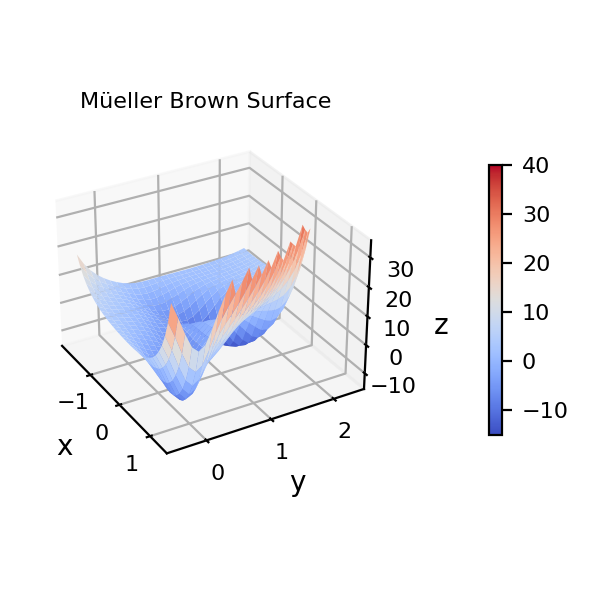

In [129]:
#@title ***Task 1.1.2) Visualizing Training Data: 3-D Projection Surface***
#@markdown We will now create a 3-D surface plot of our training data. 
#@markdown To make the plot more readable, we will copy over the points that 
#@markdown are extremely high energy with nan (not a number). This will keep 
#@markdown our Z array the same shape and help us ignore the high energy region 
#@markdown that we are not interested in. 

%matplotlib ipympl    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
import copy

fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(projection='3d')

# Made copy of Z just to clean up the plot.
clean_Z = copy.copy(Z)
clean_Z[clean_Z>35] = np.nan
#print(np.amax(clean_Z), np.amin(clean_Z))
surf=ax.plot_surface(X, Y, clean_Z, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none', vmin=-15, vmax=40)

ax.view_init(30,-30)
ax.tick_params(axis='both', pad=-2,labelsize=8)
ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("y",labelpad=-5)
ax.set_zlabel("z",labelpad=-6)
ax.set_title('Müeller Brown Surface', fontsize=8)
cbar= plt.colorbar(surf,shrink=0.5, pad=0.2)
cbar.ax.tick_params(labelsize=8)
plt.tight_layout()

plt.show()

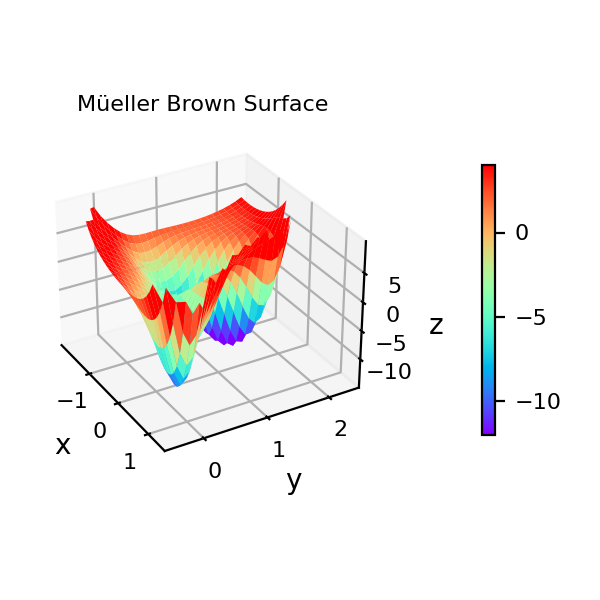

In [128]:
#@title ***Task 1.1.3) Visualizing Training Data: 3-D Projection Surface***
#@markdown Because we are keeping only the low-energy points for training (v<10, cell 1.2), 
#@markdown we will make a 3-D surface plot that more accurately reflects our training data.


%matplotlib ipympl    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
import copy


fig = plt.figure(figsize=(3,3), dpi=200)
ax = fig.add_subplot(projection='3d')

clean_Z = copy.copy(Z)
clean_Z[clean_Z>10] = np.nan

surf=ax.plot_surface(X, Y, clean_Z, rstride=1, cstride=1,
                cmap=plt.cm.rainbow, edgecolor='none', vmin=-12, vmax=4) 

ax.view_init(30,-30)
ax.tick_params(axis='both', pad=-2,labelsize=8)
ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("y",labelpad=-5)
ax.set_zlabel("z",labelpad=-6)
ax.set_title('Müeller Brown Surface', fontsize=8)
cbar= plt.colorbar(surf,shrink=0.5, pad=0.2)
cbar.ax.tick_params(labelsize=8)
plt.tight_layout()

plt.show()



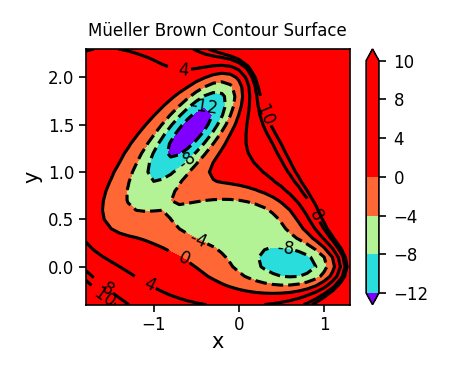

In [125]:
#@title ***Task 1.1.4) Visualizing Training Data: Contour Surface***
#@markdown Now we will create a contour surface plot of our training data

fig = plt.figure(figsize=(3,2.5), dpi=150)
levels = [-12, -8, -4, 0, 4, 8, 10]
ct = plt.contour(X, Y, Z, levels, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
plt.xlabel("x", labelpad=-0.75)
plt.ylabel("y", labelpad=2.5)
plt.tick_params(axis='both', pad=2,labelsize=8)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
plt.title('Müeller Brown Contour Surface', fontsize=8)
plt.tight_layout()
plt.show()



In [73]:
#@title ***Task 1.2) Loading PyTorch and Training Data***

#@markdown After installing and importing pytorch, we will save our training data as a tensor data set. Why tensor data set? CL

%pip install pytorch-lightning > /dev/null

import math
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

dataset = TensorDataset(Tensor(xy_truncated), Tensor(z_truncated))
train_loader = DataLoader(dataset, batch_size=32)
print("Size of training set:", len(train_loader.dataset))

Size of training set: 696


**A Basic Neural Network**

Below is a schematic of a neural netowrk. Inputs (x, y) are given weights (w) and biases (b) and are used as a value (v) for the activation function (tanh) at the input layer. The activation function decides the activity or contribution of each neuron in the input layer. Weights (w') and biases (b') are applied to the value (v') returned by the activation function and used to create the predicted value in the output layer ($V^{pred}$). 


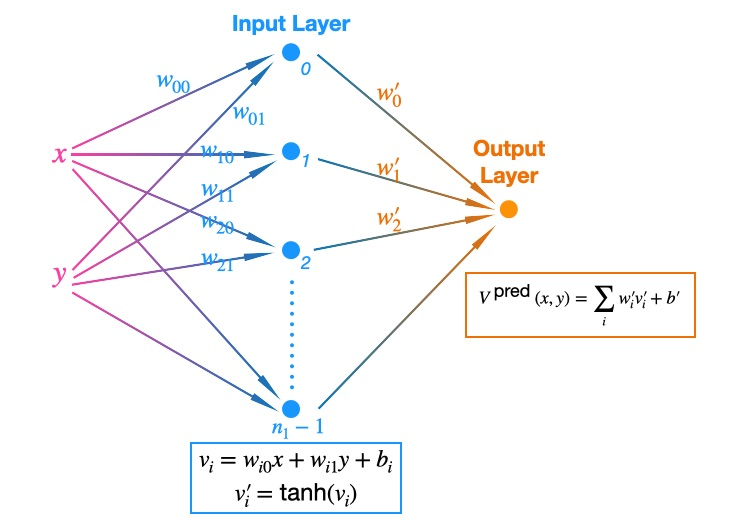

In [75]:
#@title ***Task 1.3) Defining the Neural Network Class***
#@markdown Here we define our neural network as a python class. We also define a function to loop through our training data
class NeuralNetwork(nn.Module):
    def __init__(self, n1=20):  #n1 is the number of neurons for the first layer
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,n1), # Linear function taking 2 inputs and outputs data for 20 neurons.
            nn.Tanh(),
            nn.Linear(n1, 1) # Linear function taking data from 20 neurons and producing one output value. 
        )

    def forward(self, x): 
        return self.model(x)

def train_loop(dataloader, model, optimizer, i_epoch):

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = F.mse_loss(pred.squeeze(), y)

        # Backpropagation - using the loss function gradients to update the weights and biases.
        optimizer.zero_grad() # Zero out the gradients from the previous iteration to replace them. 
        loss.backward() # Update the gradients of the loss function.
        optimizer.step() # Uses step() to optimize the weights and biases with the updated gradients. 

        if batch % 15 == 0 and i_epoch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"epoch: {i_epoch:>3d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

In [77]:
#@title ***Task 1.4) Training the Model***

#@markdown Now we can train the machine learning model. We will finish our training when the desired number of epochs has been reached. We will also define some terms used for training below. \
#@markdown Epochs - Number of forward/backward passes through the entire neural network. \
#@markdown Learning Rate - Determines the step size as we try to optimize the loss function. A faster learning rate would have a larger step size. \
#@markdown Stochastic Gradient Descent (SGD) - The algorithm used for optimizing the loss function.
# Training of Machine Learning Model

learning_rate = 1e-2
epochs = 1000
n1 = 20 
model = NeuralNetwork(n1)
loss_fn = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    train_loop(train_loader, model, optimizer, t)
    # prints: "epoch:", every 100 epochs, "loss:", error from the loss function, [   current position in traning set/ size of training set]
    # Note: In this example, there are 696 training points broken into 21 batches of batch size 32 (672 training points). 
    # That means there is an extra batch of 24 training points. When added together, this gives the full 696 training points. 
print("Done with Training!")

epoch:   0 loss:  31.044  [    0/  696]
epoch:   0 loss:  50.295  [  480/  696]
epoch: 100 loss:  16.386  [    0/  696]
epoch: 100 loss:  23.905  [  480/  696]
epoch: 200 loss:  11.057  [    0/  696]
epoch: 200 loss:   7.157  [  480/  696]
epoch: 300 loss:   7.035  [    0/  696]
epoch: 300 loss:   3.261  [  480/  696]
epoch: 400 loss:   4.214  [    0/  696]
epoch: 400 loss:   1.821  [  480/  696]
epoch: 500 loss:   2.513  [    0/  696]
epoch: 500 loss:   1.016  [  480/  696]
epoch: 600 loss:   1.472  [    0/  696]
epoch: 600 loss:   0.651  [  480/  696]
epoch: 700 loss:   0.970  [    0/  696]
epoch: 700 loss:   0.381  [  480/  696]
epoch: 800 loss:   0.875  [    0/  696]
epoch: 800 loss:   0.314  [  480/  696]
epoch: 900 loss:   0.819  [    0/  696]
epoch: 900 loss:   0.526  [  480/  696]
Done with Training!


diff, min, max: -1187.3910836128891 5.411287373208811


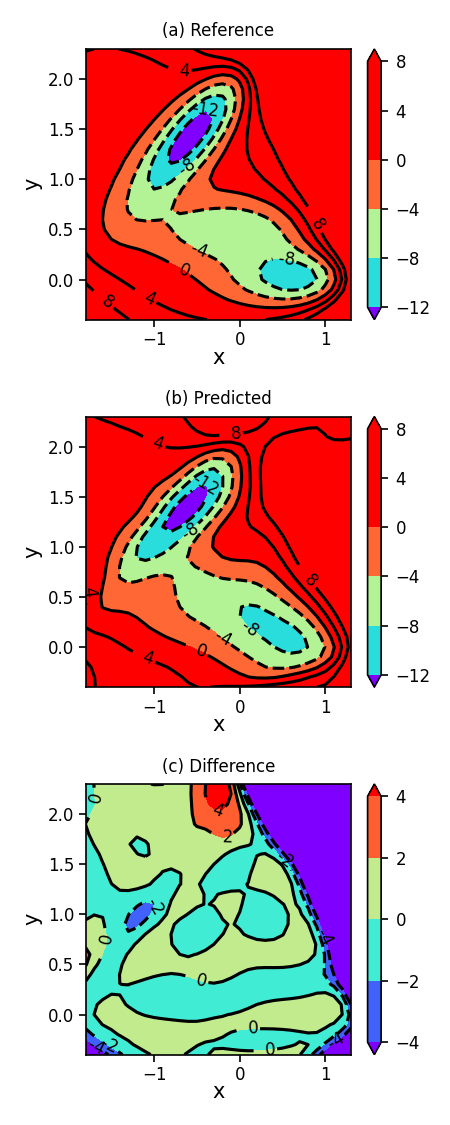

In [119]:
#@title ***Task 1.5) Plotting Reference, Predicted, and Difference Surfaces***
#@markdown Finally, we will plot the Müller-Brown potential energy surface using the analytical function (reference), using the neural network (predicted), and we will show the difference between the predicted and reference surfaces.

# Show the predicted surface, and compare to the reference one
def show_surface(model):

  z_pred = model(Tensor(xy))
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)

  fig = plt.figure(figsize=(3,7.5), dpi=150)


  plt.subplot(3, 1, 1)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("(a) Reference", fontsize=8)
  plt.xlabel("x", labelpad=-0.75)
  plt.ylabel("y", labelpad=2.5)
  plt.tick_params(axis='both', pad=2,labelsize=8)
  cbar= plt.colorbar()
  cbar.ax.tick_params(labelsize=8)

  plt.subplot(3, 1, 2)
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("(b) Predicted", fontsize=8)
  plt.xlabel("x", labelpad=-0.75)
  plt.ylabel("y", labelpad=2.5)
  plt.tick_params(axis='both', pad=2,labelsize=8)
  cbar= plt.colorbar()
  cbar.ax.tick_params(labelsize=8)


  plt.subplot(3, 1, 3)
  levels = [-4, -2, 0, 2, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend='both', vmin=-4, vmax=4)
  plt.title("(c) Difference", fontsize=8)
  plt.xlabel("x", labelpad=-0.75)
  plt.ylabel("y", labelpad=2.5)
  print("diff, min, max:", np.amin(Zdiff), np.amax(Zdiff))
  plt.tick_params(axis='both', pad=2,labelsize=8)
  cbar= plt.colorbar()
  cbar.ax.tick_params(labelsize=8)

  plt.tight_layout()

  plt.show()

show_surface(model)

In [130]:
#@title ***Task 1.6) Take a look at the NN parameters***

#@markdown In order to take a closer look at the neural network parameters, we can define the two linear functions and activation function for the neural network explicitly.
print("model:", model)

for name, param in model.named_parameters():
    #print(name, param.data)
    if name == 'model.0.weight': weights0 = param.data.detach().numpy()
    elif name == 'model.0.bias': bias0 = param.data.detach().numpy()
    elif name == 'model.2.weight': weights2 = param.data.detach().numpy()
    elif name == 'model.2.bias': bias2 = param.data.detach().numpy()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

#print("weights2:", weights2)
#print("bias2:", bias2)

#first linear function
v1 = np.zeros(n1)
for i in range(0, n1):
  v1[i] += weights0[i,0] * xy0[0] + weights0[i,1] * xy0[1] + bias0[i]

#activation function
v2 = np.zeros(n1)
for i in range(0, n1):
  v2[i] = tanh(v1[i])

#second linear function
z_pred = 0.0
for i in range(0, n1):
  z_pred += weights2[0,i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

#print(model[0].weight)

model: NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
z0: tensor([-13.5914], grad_fn=<AddBackward0>) z_pred: -13.59143054154325


In [ ]:
#@title ***Task 1.6.1) A more automated/refined implementation***

#@markdown Below is a more professional implementation of the neural network that saves epoch infromation in the logs_csv/ directory.

class pl_model(pl.LightningModule):
    def __init__(self, n1=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,n1),
            nn.Tanh(),
            nn.Linear(n1, 1)
        )
        self.learning_rate = 1e-2

    def forward(self, x): 
        return self.model(x)

    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        loss = F.mse_loss(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        # Using the Adam optimzation algorithm instead of SGD. 
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 1,
                    }
        return [optimizer]#, [scheduler]

csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=1000, logger=csv_logger)
n1 = 20
model = pl_model(n1)
trainer.fit(model, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs_csv/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81    
-------------------------------------
81        Trainable params
0         Non-trainable params
81        Total params
0.000     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarn

Training: 0it [00:00, ?it/s]

In [17]:
#@title ***Task 1.6.2) Plotting Training Error***
#@markdown Now we can plot the training error as the number of epochs increases.

import pandas as pd
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")

fig, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Errors")


Text(0, 0.5, 'Training Errors')

Error in callback <function flush_figures at 0x7fce2c618280> (for post_execute):


KeyboardInterrupt: ignored

diff, min, max: -1183.99884261176 11.377713020301389


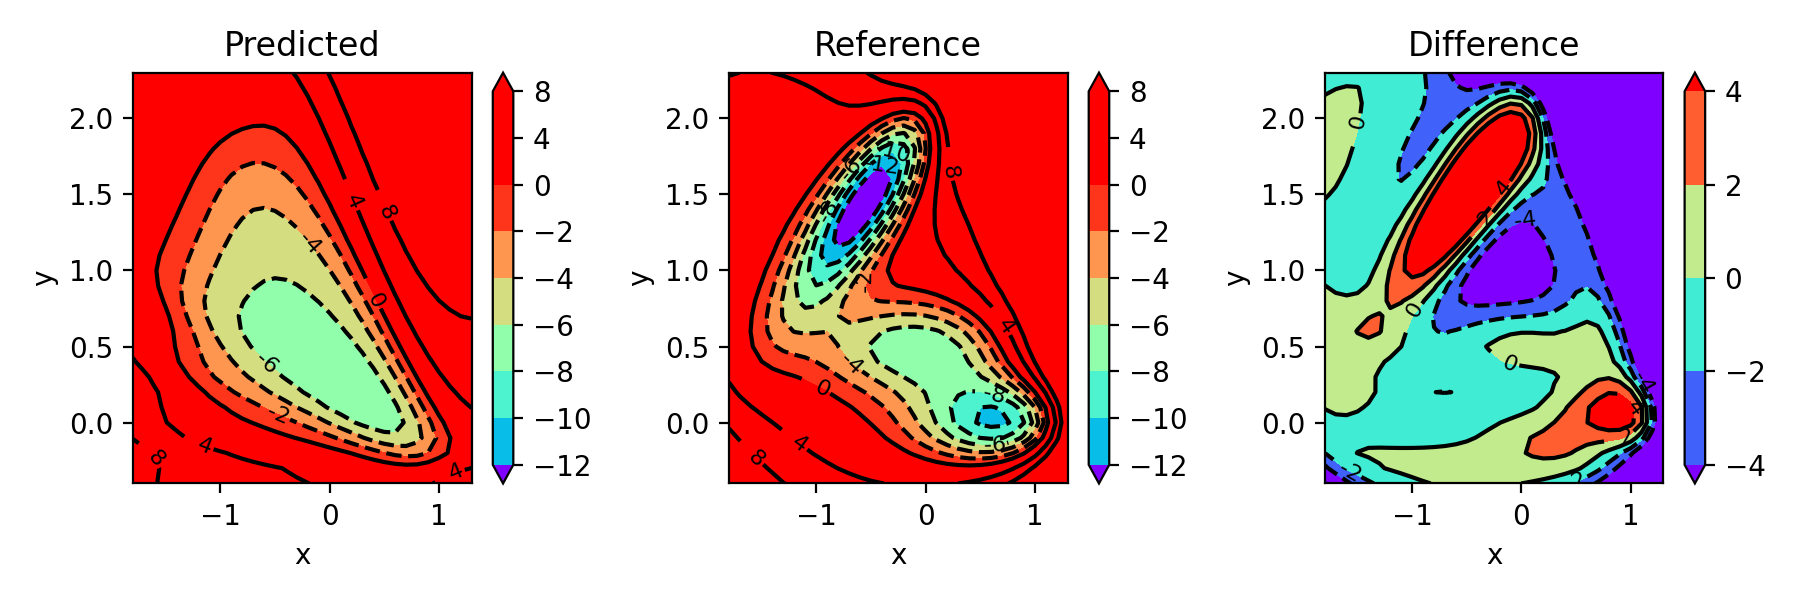

In [18]:
#@title ***Task 1.6.3) Plotting Reference, Predicted, and Difference Surfaces***
#@markdown Again, we plot the reference, predicted, and difference surfaces using the more refined neural network implementation.

show_surface(model)